# PS5 Solutions

## Part 1

### Problem 1

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

import sklearn.datasets
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.model_selection
import sklearn.metrics

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Problem 2

In [2]:
bunch_nasa = sklearn.datasets.fetch_openml(
    data_id=42821,
    as_frame=True
)

/home/curt/mambaforge/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


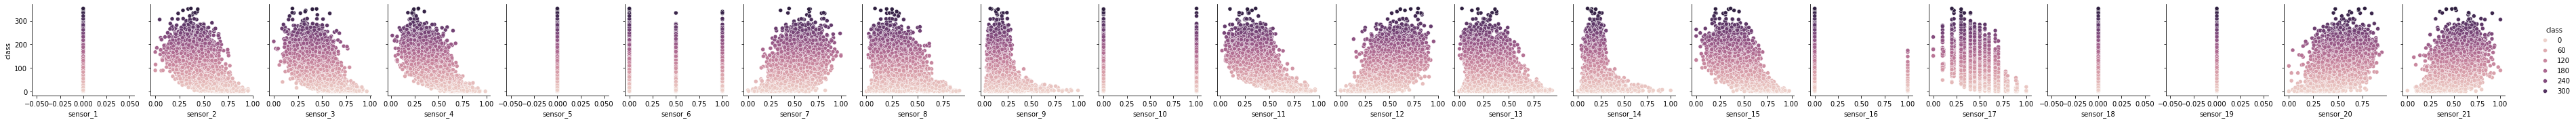

In [28]:
sns.pairplot(
    data=bunch_nasa.frame.sample(frac=0.1),
    y_vars="class",
    hue="class"
)

sensor_1, sensor_5, sensor_6, sensor_10, sensor_16, sensor_18, sensor_19 all look like they aren't helpful.

Nothing looks linear, unfortunately.  The output might be nonlinear.  We can check how many samples we have of the targets with a histogram of the target as well:

<Axes: xlabel='class', ylabel='Count'>

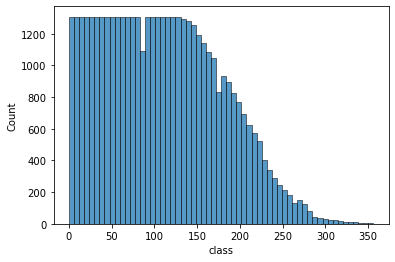

In [5]:
sns.histplot(data=bunch_nasa.target)

Looks like we will have a bit of an imbalance with the training set.  We may want to selectively subsample so that the upper end doesn't get lost, see: https://stats.stackexchange.com/questions/575378/stratification-of-the-continuous-y-target-variable-in-regression-setting

In [11]:
np.any(bunch_nasa.data.isna())  # check for malformed rows.

False

### Problem 4

To try to get a better pattern, I'll try to make the data be about the same flat histogram, meaning that any target values lower than 250 will be reduced to just 200 samples each bin.  It's about 8 bins for every 50, so we'll have 40 bins to choose from for everything less than 250.  That comes to about 40 bins * 200 samples per bin, which is a sample size of 8000.

My pipeline will just include some sort of scaling to shift the mean/median to 0.0, and selectkbest for the top 6 features.

In [36]:
df_nasa_clean_lower = bunch_nasa.frame[bunch_nasa.frame["class"] < 250].sample(n=32*200)
df_nasa_clean_full = pd.concat([
        df_nasa_clean_lower, 
        bunch_nasa.frame[bunch_nasa.frame["class"] >= 250]
    ]).drop(
        columns=["sensor_1", "sensor_5", "sensor_6", "sensor_10", "sensor_16", "sensor_18", "sensor_19"])
df_nasa_clean_full.describe()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,class
count,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000
mean,0.440491,0.433870,0.421319,0.534604,0.257002,0.176052,0.407746,0.530532,0.268300,0.200378,0.436523,0.452481,0.518797,0.535414,129.474405
std,0.143381,0.137010,0.153760,0.144822,0.146760,0.091920,0.164044,0.146338,0.157280,0.087679,0.155008,0.151795,0.148027,0.143014,84.572012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.342857,0.340651,0.310593,0.439437,0.158730,0.121463,0.291971,0.434375,0.158537,0.148893,0.324253,0.333333,0.421053,0.441181,59.000000
50%,0.431373,0.425413,0.407962,0.535885,0.215873,0.159783,0.387324,0.533333,0.222561,0.186214,0.420692,0.444444,0.522222,0.540953,119.000000
75%,0.531429,0.519610,0.514952,0.633971,0.314286,0.205048,0.503650,0.634375,0.333333,0.230998,0.531593,0.555556,0.622222,0.632321,188.000000
max,1.000000,0.942019,1.000000,1.000000,0.990228,1.000000,1.000000,0.971014,0.996951,1.000000,1.000000,1.000000,1.000000,1.000000,356.000000


<Axes: xlabel='class', ylabel='Count'>

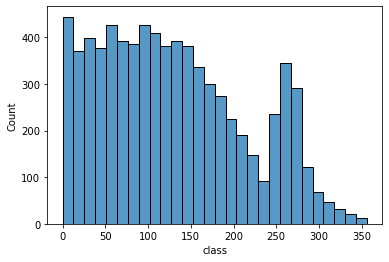

In [37]:
sns.histplot(data=df_nasa_clean_full["class"])

It's not a perfect subsample, but it's better than it was before.

In [39]:
nasa_X_train, nasa_X_test, nasa_y_train, nasa_y_test = sklearn.model_selection.train_test_split(
    df_nasa_clean_full.drop(columns=["class"]), 
    df_nasa_clean_full["class"], 
    test_size=0.3, 
    random_state=7
)

In [46]:
nasa_linear_mlp_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", sklearn.neural_network.MLPRegressor(
        hidden_layer_sizes=(),
        learning_rate_init=0.2,
        max_iter=1000
    ))
]

nasa_linear_mlp_pipeline = sklearn.pipeline.Pipeline(nasa_linear_mlp_pipeline_steps)

### Problem 5

In [47]:
nasa_linear_mlp_pipeline.fit(nasa_X_train, nasa_y_train)

Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_regression at 0x7fade3932680>)),
                ('scaler', RobustScaler()),
                ('estimator',
                 MLPRegressor(hidden_layer_sizes=(), learning_rate_init=0.2,
                              max_iter=1000))])

In [48]:
nasa_linear_mlp_pipeline.score(nasa_X_test, nasa_y_test)

0.5298677780212548

<Axes: ylabel='class'>

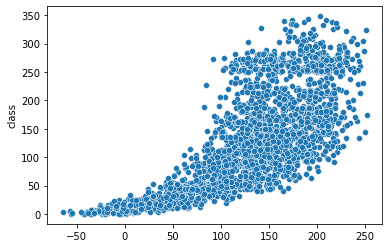

In [49]:
sns.scatterplot(y=nasa_y_test, x=nasa_linear_mlp_pipeline.predict(nasa_X_test))

In [50]:
sklearn.metrics.mean_absolute_error(y_true=nasa_y_test, y_pred=nasa_linear_mlp_pipeline.predict(nasa_X_test))

46.32619248277391

In [52]:
nasa_linear_mlp_pipeline.named_steps["estimator"].coefs_

[array([[-11.72329253],
        [-10.52704023],
        [-22.08417519],
        [-23.61838127],
        [-15.48588235],
        [-12.23134021]])]

In [54]:
nasa_linear_mlp_pipeline.named_steps["estimator"].intercepts_

[array([136.04225794])]

### Problem 6

In [55]:
nasa_mlp_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", sklearn.neural_network.MLPRegressor(
        hidden_layer_sizes=(26, 26,),
        learning_rate_init=0.2,
        max_iter=1000
    ))
]

nasa_mlp_pipeline = sklearn.pipeline.Pipeline(nasa_mlp_pipeline_steps)

In [56]:
nasa_mlp_pipeline.fit(nasa_X_train, nasa_y_train)

Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_regression at 0x7fade3932680>)),
                ('scaler', RobustScaler()),
                ('estimator',
                 MLPRegressor(hidden_layer_sizes=(26, 26),
                              learning_rate_init=0.2, max_iter=1000))])

<Axes: ylabel='class'>

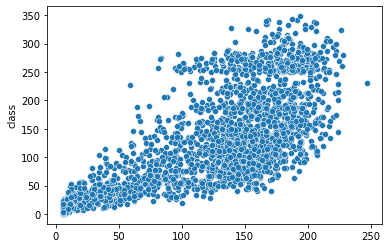

In [57]:
sns.scatterplot(y=nasa_y_test, x=nasa_mlp_pipeline.predict(nasa_X_test))

In [58]:
sklearn.metrics.mean_absolute_error(y_true=nasa_y_test, y_pred=nasa_mlp_pipeline.predict(nasa_X_test))

44.108467191359075

In [65]:
nasa_mlp_pipeline.named_steps["estimator"].coefs_

[array([[ 5.31707613e-01, -2.01104999e-01,  1.00114881e+00,
          5.76141559e-02, -6.91703498e-02,  7.19695234e-01,
         -5.80947760e-01, -7.84984610e-02,  3.13644335e-01,
         -7.71959572e-02,  3.43678786e-01, -5.37535393e-01,
          1.65494034e-01,  1.51720353e+00,  3.84958209e-02,
         -3.08087692e-01, -2.85985604e-01, -7.45598183e-01,
         -7.10230623e-01,  3.36881166e-04,  2.30447744e-01,
          1.70115742e+00,  2.35616482e-01,  1.04783442e+00,
          6.01639727e-01,  9.71733308e-01],
        [ 1.29977740e+00, -4.08472318e-01,  7.72854835e-01,
          5.88238068e-01, -7.10010220e-01, -1.30852916e-01,
          1.11669219e+00, -2.26532631e-01,  1.14567091e-01,
          1.09932215e+00,  6.11570205e-02,  4.57194440e-01,
          1.74785709e-01,  1.19154720e+00, -2.90022856e-01,
          7.69067943e-02, -2.24625355e-01,  1.59648169e+00,
         -3.29157339e-01,  3.85083831e-01, -6.13398038e-02,
          6.86773671e-01, -1.62203426e-01, -3.14692546e-

In [61]:
nasa_mlp_pipeline.named_steps["estimator"].intercepts_

[array([-2.74160685,  1.33538233, -0.19519693, -3.12665125,  2.84880606,
         0.64307405,  1.23085341,  1.62798987, -0.70384108, -0.89038159,
        -1.8402965 , -0.65637598, -1.29225152, -2.69146748,  2.29044671,
         1.49452552,  1.97912868, -0.30917001,  0.93001248, -1.3957248 ,
        -2.78353683, -1.74141957,  2.13070951,  0.52003475,  2.0787258 ,
        -1.49384773]),
 array([-1.39370009,  2.89110628, -1.38894664,  4.3766019 , -1.00056448,
         3.61149873, -1.12139036, -1.11942277,  2.22516168,  2.84720971,
        -1.3210038 ,  2.77244747, -1.44551344,  3.98741247,  4.51620662,
         3.12434683,  2.30662643, -1.36322076,  3.70123561,  3.07242349,
         2.68284603, -1.2720657 ,  2.79888551, -0.90549721, -1.20552502,
         2.43235257]),
 array([5.29047349])]

The performance is a lot better now -- we no longer have negative targets.  The MAE is only a little bit lower, but at least the target bounds match the original bounds now.

## Part 2

In [72]:
nasa_mlp_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", sklearn.neural_network.MLPRegressor(
        # hidden_layer_sizes=(26, 26,),
        learning_rate_init=0.4,
        early_stopping=True,
        validation_fraction=0.125,
        n_iter_no_change=10,
        tol=1e-4,
        max_iter=10000
    ))
]

nasa_mlp_pipeline = sklearn.pipeline.Pipeline(nasa_mlp_pipeline_steps)

In [74]:
param_grid = {
    "estimator__hidden_layer_sizes": (
        (26, 26,),
        (30, 30,),
        (10, 10,),
        (26, 26, 26,),
        (30, 30, 30,),
        (10, 10, 10,),
        (30, 26, 10,),
    ),
}

In [75]:
nasa_mlp_cv = sklearn.model_selection.GridSearchCV(
    nasa_mlp_pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
    verbose=3,
    return_train_score=True
)

In [76]:
nasa_mlp_cv.fit(nasa_X_train, nasa_y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x7fade3932680>)),
                                       ('scaler', RobustScaler()),
                                       ('estimator',
                                        MLPRegressor(early_stopping=True,
                                                     learning_rate_init=0.4,
                                                     max_iter=10000,
                                                     validation_fraction=0.125))]),
             n_jobs=2,
             param_grid={'estimator__hidden_layer_sizes': ((26, 26), (30, 30),
                                                           (10, 10),
                                                           (26, 26, 26),
                                                           (30, 30, 30),
                                                           (10, 10, 10),
                                                           (30, 26, 10))},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=3)

In [77]:
nasa_mlp_cv.best_params_

{'estimator__hidden_layer_sizes': (30, 30)}

Looks like, interestingly enough, more layers doesn't necessarily help us!

In [79]:
pd.DataFrame(nasa_mlp_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.390891,0.057679,0.002219,0.000040,"(26, 26)","{'estimator__hidden_layer_sizes': (26, 26)}",-44.164962,-44.798519,-45.690919,-44.318227,-46.891400,-45.172805,1.010757,3,-44.389182,-45.430926,-44.652342,-45.568855,-45.013762,-45.011013,0.447848
1,0.457921,0.016221,0.002172,0.000064,"(30, 30)","{'estimator__hidden_layer_sizes': (30, 30)}",-44.311317,-44.235490,-45.376413,-43.254292,-46.564737,-44.748450,1.129598,1,-44.699294,-44.590153,-44.255627,-44.656043,-44.120809,-44.464385,0.232102
2,0.343425,0.023713,0.004943,0.004060,"(10, 10)","{'estimator__hidden_layer_sizes': (10, 10)}",-44.200737,-44.091714,-45.506300,-43.810833,-46.185137,-44.758944,0.921767,2,-44.556297,-44.910764,-44.309264,-45.262045,-43.668375,-44.541349,0.542594
3,0.531502,0.144509,0.002404,0.000122,"(26, 26, 26)","{'estimator__hidden_layer_sizes': (26, 26, 26)}",-45.581919,-44.791714,-46.677145,-68.445327,-46.597704,-50.418762,9.040088,6,-45.587218,-45.220082,-45.549660,-69.531793,-44.762441,-50.130239,9.705297
4,0.815524,0.328576,0.002730,0.000060,"(30, 30, 30)","{'estimator__hidden_layer_sizes': (30, 30, 30)}",-45.419244,-69.034212,-45.895419,-68.955003,-47.424801,-55.345736,11.163973,7,-45.674918,-71.008649,-44.759013,-70.654103,-45.149131,-55.449163,12.563388
5,0.402730,0.034294,0.001669,0.000200,"(10, 10, 10)","{'estimator__hidden_layer_sizes': (10, 10, 10)}",-44.587323,-45.624719,-45.967359,-45.131118,-46.647014,-45.591507,0.703819,4,-44.912149,-45.532358,-44.713442,-46.428303,-44.650218,-45.247294,0.667812
6,0.610239,0.078872,0.002513,0.000267,"(30, 26, 10)","{'estimator__hidden_layer_sizes': (30, 26, 10)}",-44.326775,-44.369688,-45.679757,-43.882004,-72.985220,-50.248689,11.384124,5,-44.615108,-44.781923,-44.636457,-45.217091,-69.490532,-49.748222,9.873531


Even more odd, (10, 10) did almost as well as (30, 30)!